# Quick Hack to get Profile Reliablity for 2 HCP Subjects for 5 bundles

In [1]:
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import CCMetric
from dipy.viz import regtools
import os
import os.path as op
import time

from itertools import chain

import numpy as np
import pandas as pd

from AFQ import api
import AFQ.data as afd

import nibabel as nib

from dipy.io.streamline import load_tractogram
from dipy.stats.analysis import afq_profile, gaussian_weights
from dipy.tracking.streamline import set_number_of_points, values_from_volume

from scipy.interpolate import splprep, splev

from fastdtw import fastdtw

# %matplotlib widget

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import logging

logger = logging.getLogger('dipy.align.imwarp')
logger.setLevel(logging.CRITICAL)

hcp_subjects = ['103818', '105923']

def get_hcp_afq(dataset_name):
    afq = api.AFQ(
        bids_path=op.join(afd.afq_home, dataset_name),
        dmriprep='dmriprep'
    )
    
    display(afq.data_frame)
    
    return afq

hcp_test_afq = get_hcp_afq('HCP_1200')

hcp_retest_afq = get_hcp_afq('hcp_retest')

bundle_names = [*hcp_retest_afq.bundle_dict]
bundle_names = ['ARC_L', 'ARC_R', 'CST_L', 'CST_R', 'FP'] 
n_points = 100

def get_subject_iloc(afq, subject):
    iloc = afq.data_frame.index[afq.data_frame['subject'] == subject][0]
    
    return iloc

def get_subject_scalar_data(afq, subject, scalar):
    iloc = get_subject_iloc(afq, subject)
    
    scalar_filename = afq._get_fname(
        afq.data_frame.iloc[iloc],
        f'_model-{scalar}.nii.gz'
    )

    scalar_data = nib.load(scalar_filename).get_fdata()
    
    return scalar_data

def get_subject_bundle_tractogram(afq, subject, bundle_name):
    iloc = get_subject_iloc(afq, subject)
    
    results_dir = afq.data_frame.iloc[iloc]['results_dir']
    
    fname = op.split(
        afq._get_fname(
            afq.data_frame.iloc[iloc],
            f'-{bundle_name}'
            f'_tractography.trk',
            include_track=True,
            include_seg=True
        )
    )

    tractogram_filename = op.join(results_dir, 'clean_bundles', fname[1])
    
    tractogram = load_tractogram(tractogram_filename, 'same')
    
    return tractogram

/Users/bloomdt/anaconda/envs/dtw/lib/python3.8/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/templates 
INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/callosum_templates 
/Users/bloomdt/anaconda/envs/dtw/lib/python3.8/site-packages/bids/layout/models.py:98: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


subject                                           dwi_file  \
0  100307  /Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...   
1  103818  /Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...   
2  105923  /Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...   

                                           bvec_file  \
0  /Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...   
1  /Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...   
2  /Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...   

                                           bval_file custom_tract reg_subject  \
0  /Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...         None        None   
1  /Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...         None        None   
2  /Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...         None        None   

  ses                                             timing  \
0  01  {'Tractography': 0, 'Registration': 0, 'Segmen...   
1  01  {'Tractography': 0, 'Registration': 0, 'Segmen...   
2  01  {'Tractography': 0, 'Registration': 0, 'Segmen...   

                                         results_dir  \
0  /Users/bloomdt/AFQ_data/HCP_1200/derivatives/a...   
1  /Users/bloomdt/AFQ_data/HCP_1200/derivatives/a...   
2  /Users/bloomdt/AFQ_data/HCP_1200/derivatives/a...   

                                                gtab  \
0  <dipy.core.gradients.GradientTable object at 0...   
1  <dipy.core.gradients.GradientTable object at 0...   
2  <dipy.core.gradients.GradientTable object at 0...   

                                          dwi_affine  \
0  [[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...   
1  [[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...   
2  [[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...   

                                             dwi_img  
0  <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...  
1  <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...  
2  <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...

INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/templates 
INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/callosum_templates 
/Users/bloomdt/anaconda/envs/dtw/lib/python3.8/site-packages/bids/layout/models.py:98: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


subject                                           dwi_file  \
0  103818  /Users/bloomdt/AFQ_data/hcp_retest/derivatives...   
1  105923  /Users/bloomdt/AFQ_data/hcp_retest/derivatives...   

                                           bvec_file  \
0  /Users/bloomdt/AFQ_data/hcp_retest/derivatives...   
1  /Users/bloomdt/AFQ_data/hcp_retest/derivatives...   

                                           bval_file custom_tract reg_subject  \
0  /Users/bloomdt/AFQ_data/hcp_retest/derivatives...         None        None   
1  /Users/bloomdt/AFQ_data/hcp_retest/derivatives...         None        None   

  ses                                             timing  \
0  01  {'Tractography': 0, 'Registration': 0, 'Segmen...   
1  01  {'Tractography': 0, 'Registration': 0, 'Segmen...   

                                         results_dir  \
0  /Users/bloomdt/AFQ_data/hcp_retest/derivatives...   
1  /Users/bloomdt/AFQ_data/hcp_retest/derivatives...   

                                                gtab  \
0  <dipy.core.gradients.GradientTable object at 0...   
1  <dipy.core.gradients.GradientTable object at 0...   

                                          dwi_affine  \
0  [[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...   
1  [[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...   

                                             dwi_img  
0  <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...  
1  <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...

In [13]:
n = n_points
m = int(n/2)
stack = True
r = 4

metric = CCMetric(dim=2, radius=4)
level_iters = [200, 100, 50, 25]
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter=50)


def get_subject_diffeomorphic_bundle_profile(afq, subject, scalar_data, bundle_name, show_streamline_profiles=False):
    tractogram = get_subject_bundle_tractogram(afq, subject, bundle_name)
        
    if len(tractogram.streamlines) == 0:
        print(subject, bundle_name, 'no streamlines!')
        return np.zeros(n_points)

    fgarray = set_number_of_points(tractogram.streamlines, n_points)

    values = np.array(values_from_volume(scalar_data, fgarray, tractogram.affine))
    mean_values = np.mean(values, axis=0)
    
    plt.figure()
    plt.title(f'{subject} {bundle_name} mean bundle profile')
    plt.plot(mean_values.T, c='k', label='bundle $\mu$')
    plt.legend()
    plt.show()
    
    static = np.zeros((n, 100))

    if stack:
        for i in range(n):
            static[i] = mean_values
    else:
        static[m] = mean_values

    tic = time.perf_counter()
    transformed_values = []

    for value in values:
        moving = np.zeros((n, 100))

        if stack:
            for i in range(n):
                moving[i] = value
        else:
            moving[m] = value
            
        

        mapping = sdr.optimize(static, moving)
        
        warped_moving = mapping.transform(moving, 'linear')
        
        # the extra np logic allows to handle stacked 1D images or zero padded
        transformed_values.append(np.mean(warped_moving[np.where(np.count_nonzero(warped_moving, axis=1))], axis=0))
        
        if np.random.choice([0, 1], size=1, p=[0.999, 0.001]):
            regtools.overlay_images(static, moving, 'Static', 'Overlay', 'Moving')
            regtools.plot_2d_diffeomorphic_map(mapping)
            regtools.overlay_images(static, warped_moving, 'Static', 'Overlay', 'Warped moving')
            
            plt.plot(mean_values, label='bundle $\mu$', c='k')
            plt.plot(transformed_values[-1], label='streamline $\mu^{\prime}$', color='tab:blue')
            plt.plot(value, label='original', color='tab:blue', linestyle='dashed')
            plt.title(f'randomly selected diffeomorhphic transform streamline profile\nstacked={stack}; n={n}; radius={r}; iters={level_iters}')
#             plt.ylabel(scalar)
#             plt.xlabel('node')
            plt.legend()
            plt.show()

    transformed_values = np.array(transformed_values)
    toc = time.perf_counter()
    print(f'diffeomorphic calculation {toc - tic:0.4f} seconds')
    print(transformed_values.shape)

    mean_transformed_values = np.mean(transformed_values, axis=0)

    plt.figure()
    plt.title(f'{subject} {bundle_name} $\mu$-reference warped streamline profiles')
    plt.plot(mean_values.T, c='k', label='bundle $\mu$')
    plt.plot(mean_transformed_values.T, c='tab:blue', label='bundle $\mu^{\prime}$', linestyle='dashed')
    plt.legend()
    plt.show()

    return mean_transformed_values

def get_diffeomorphic_bundle_profiles(afq):
    mean_transformed_bundle_profiles = {}
    
    for subject in hcp_subjects:
        mean_transformed_bundle_profiles[subject] = {}
        iloc = get_subject_iloc(afq, subject)

        for scalar in afq.scalars:
            mean_transformed_bundle_profiles[subject][scalar] = {}
            scalar_data = get_subject_scalar_data(afq, subject, scalar)

            for bundle_name in bundle_names:
                mean_transformed_values = get_subject_diffeomorphic_bundle_profile(afq, subject, scalar_data, bundle_name, bundle_name == 'SLF_L')
#                 mean_transformed_values = get_subject_diffeomorphic_bundle_profile(afq, subject, scalar_data, bundle_name)
                mean_transformed_bundle_profiles[subject][scalar][bundle_name] = mean_transformed_values
                
    return mean_transformed_bundle_profiles

def get_test_retest_diffeomorphic_bundle_profile_correlations(show_bundle_profile=False, show_correlations=False):
    correlations = {}

    print('test')
    test_bundle_profiles = get_diffeomorphic_bundle_profiles(hcp_test_afq)
    display(pd.DataFrame.from_dict(test_bundle_profiles))

    print('retest')
    retest_bundle_profiles = get_diffeomorphic_bundle_profiles(hcp_retest_afq)
    display(pd.DataFrame.from_dict(retest_bundle_profiles))

    for scalar in hcp_retest_afq.scalars:
        correlations[scalar] = {}
        for subject in hcp_subjects:
            correlations[scalar][subject] = {}
            for bundle_name in bundle_names:
                test_profile = test_bundle_profiles[subject][scalar][bundle_name]
                retest_profile = retest_bundle_profiles[subject][scalar][bundle_name]

                plt.figure()
                plt.title(f'{scalar} {subject} {bundle_name} bundle profiles')
                plt.plot(test_profile, label='test')
                plt.plot(retest_profile, label='retest')
                plt.xlabel('index')
                plt.ylabel(scalar)
                plt.legend()
                plt.show()

                test_retest_corr_matrix = pd.DataFrame(zip(*[test_profile, retest_profile]), columns=['test', 'retest']).corr()
                
                # select only the upper triangle off diagonals of the correlation matrix
                test_retest_corr = test_retest_corr_matrix.where(np.triu(np.ones(test_retest_corr_matrix.shape), 1).astype(np.bool)).stack()
                
                if show_correlations:
                    print(scalar, subject, bundle_name, 'test-retest correlation:\n', test_retest_corr)
                
                if len(test_retest_corr) == 1:
                    correlations[scalar][subject][bundle_name] = test_retest_corr[0]
                else:
                    correlations[scalar][subject][bundle_name] = 0
                
    return correlations

test


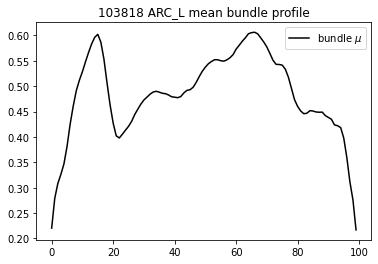

diffeomorphic calculation 1560.5744 seconds
(1121, 100)


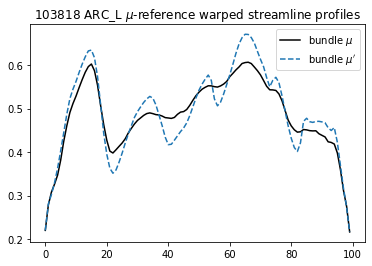

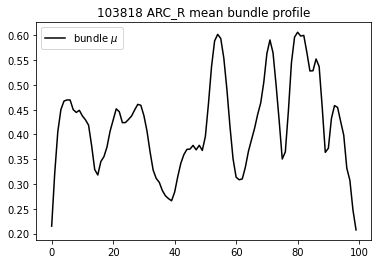

diffeomorphic calculation 37.2080 seconds
(31, 100)


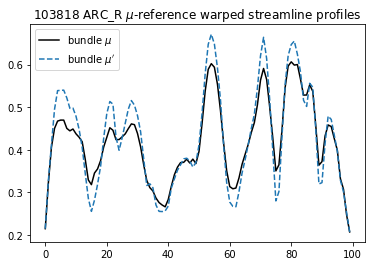

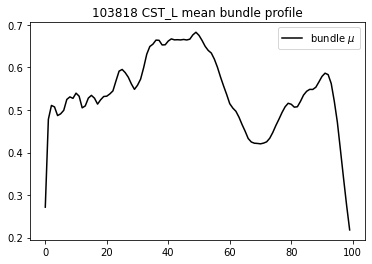

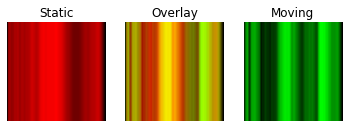

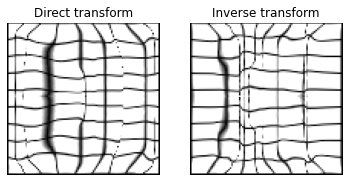

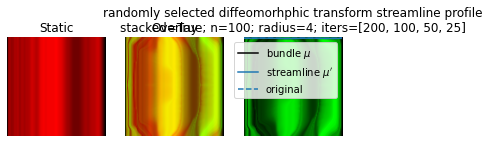

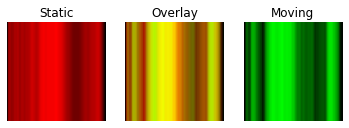

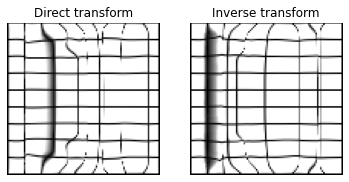

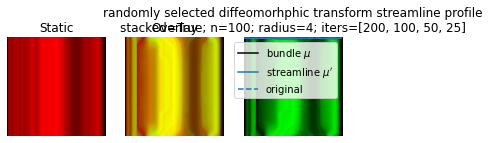

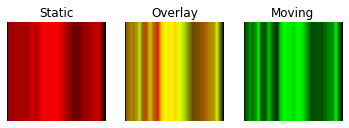

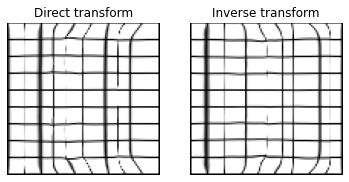

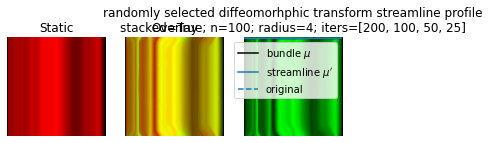

diffeomorphic calculation 3032.4608 seconds
(2373, 100)


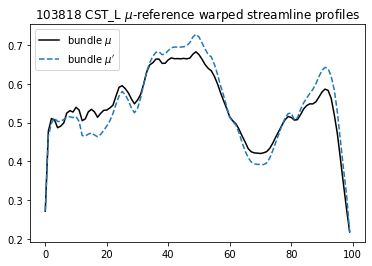

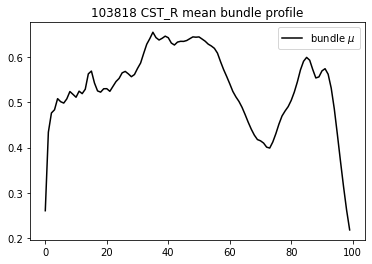

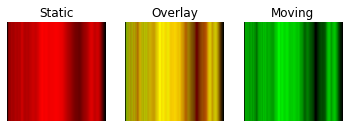

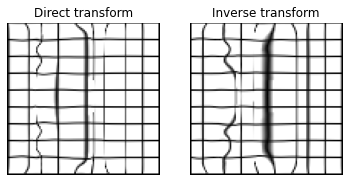

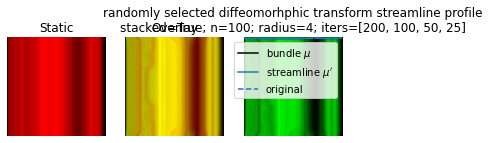

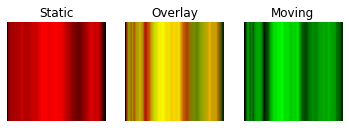

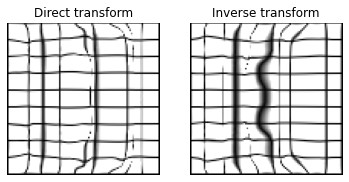

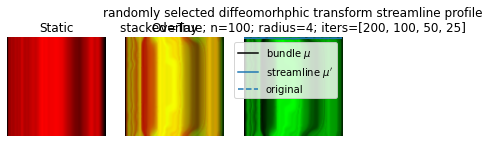

diffeomorphic calculation 2221.9278 seconds
(2061, 100)


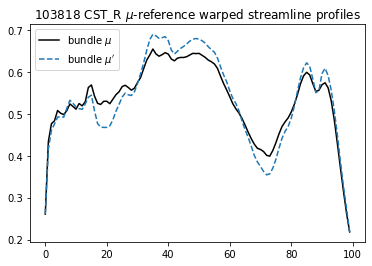

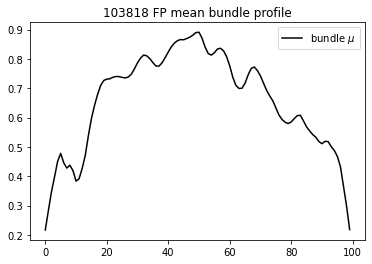

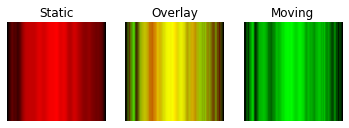

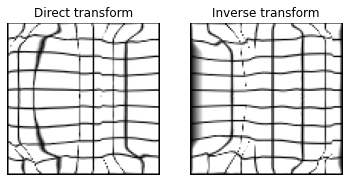

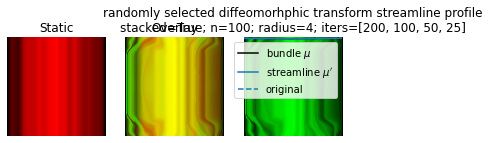

diffeomorphic calculation 589.0097 seconds
(566, 100)


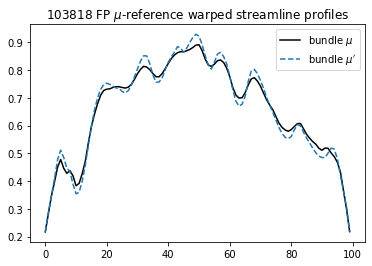

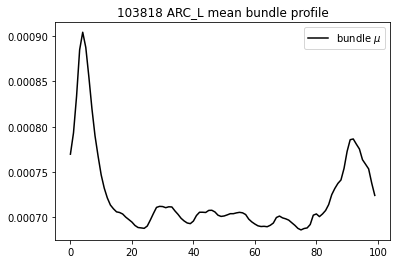

diffeomorphic calculation 1368.7634 seconds
(1121, 100)


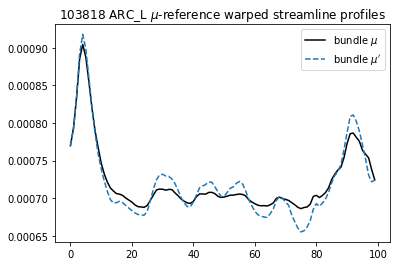

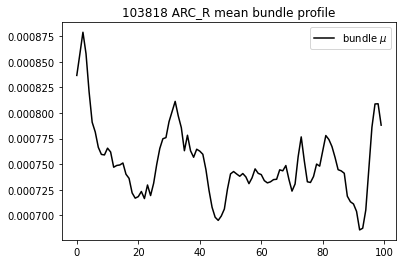

diffeomorphic calculation 27.8828 seconds
(31, 100)


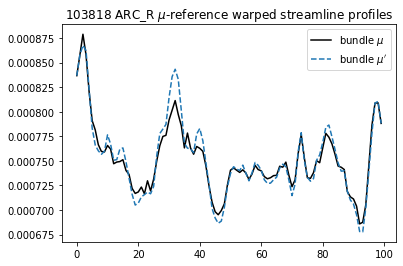

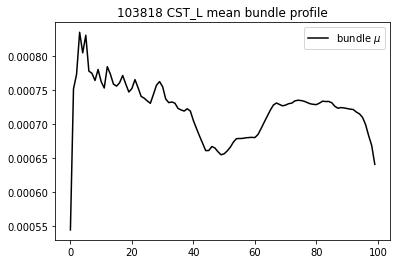

diffeomorphic calculation 2691.8371 seconds
(2373, 100)


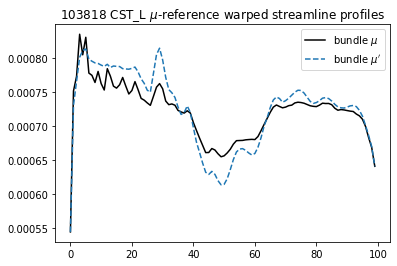

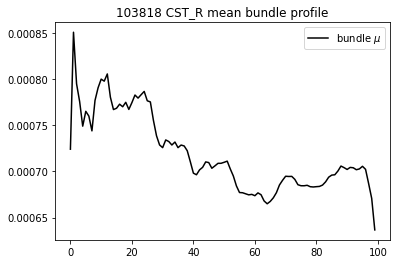

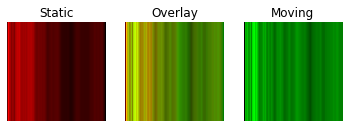

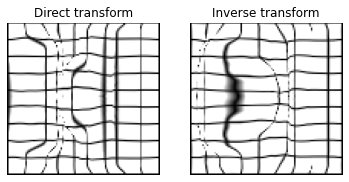

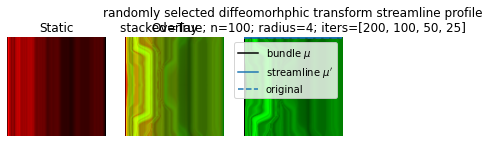

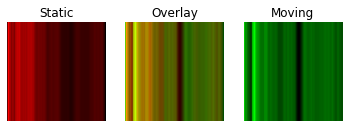

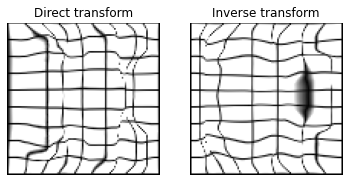

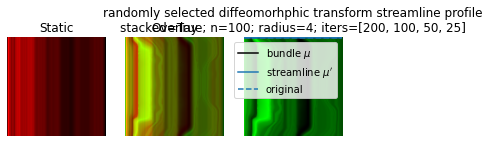

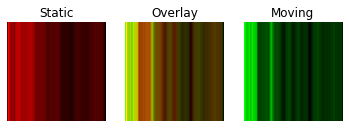

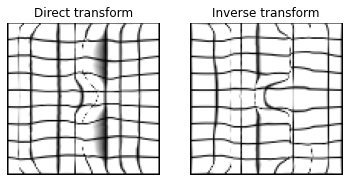

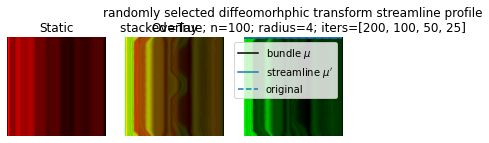

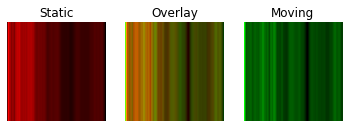

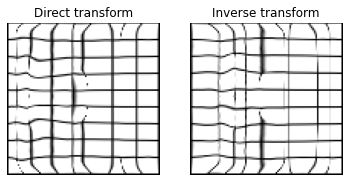

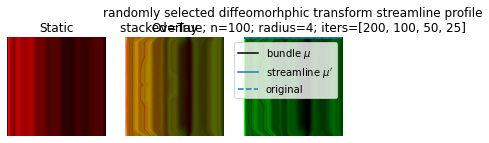

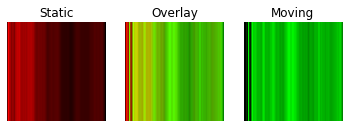

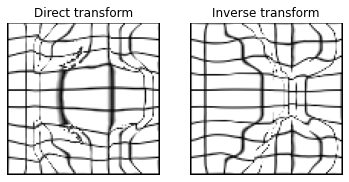

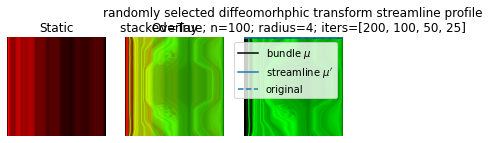

diffeomorphic calculation 2473.8087 seconds
(2061, 100)


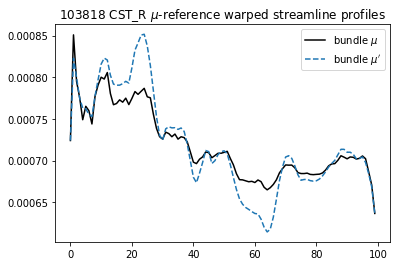

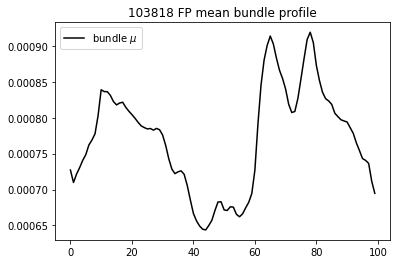

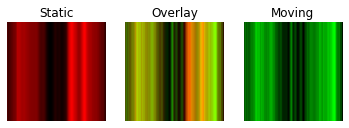

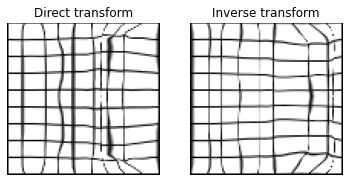

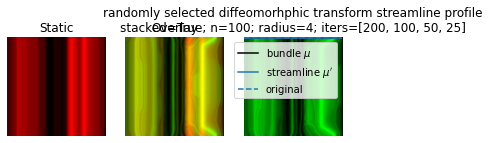

diffeomorphic calculation 626.4495 seconds
(566, 100)


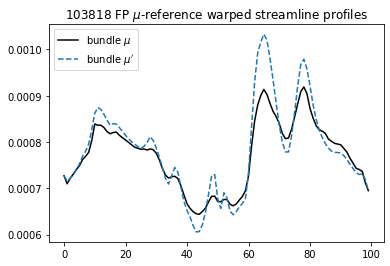

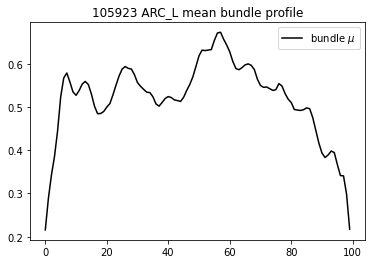

diffeomorphic calculation 395.4989 seconds
(389, 100)


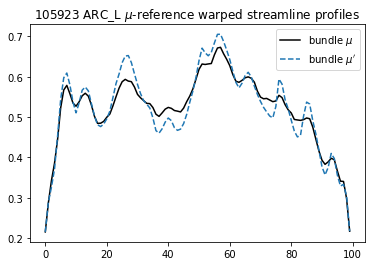

105923 ARC_R no streamlines!


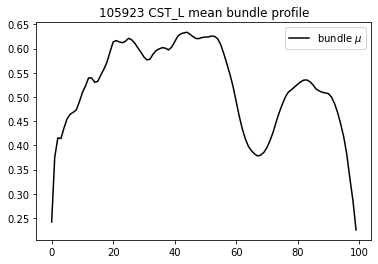

diffeomorphic calculation 973.5731 seconds
(896, 100)


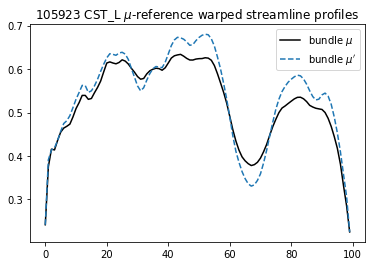

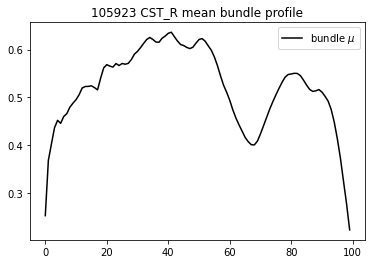

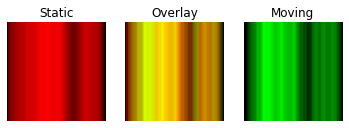

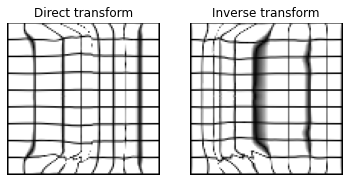

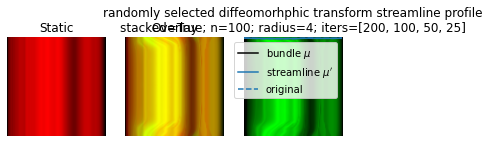

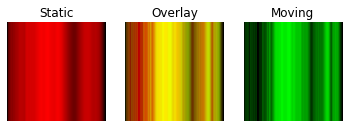

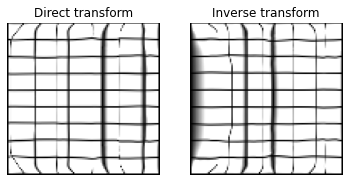

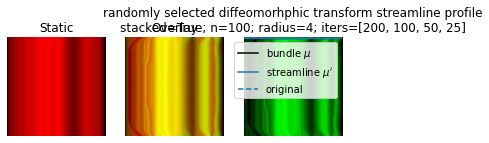

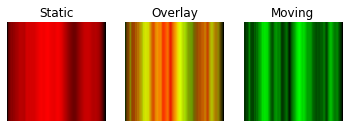

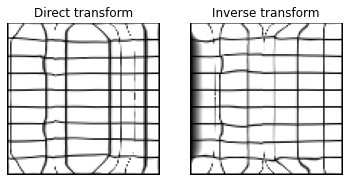

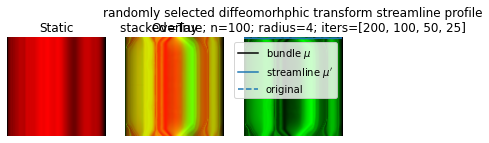

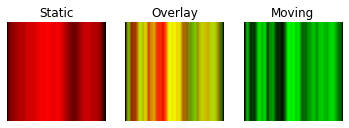

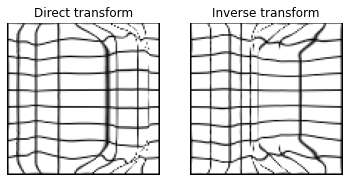

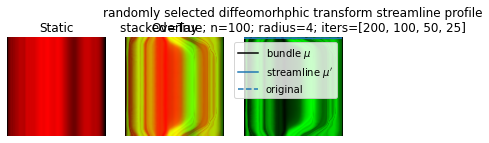

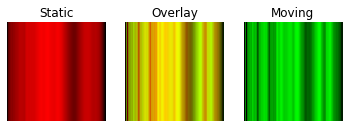

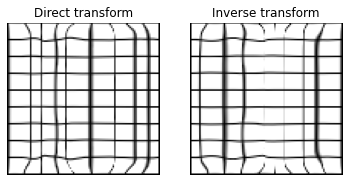

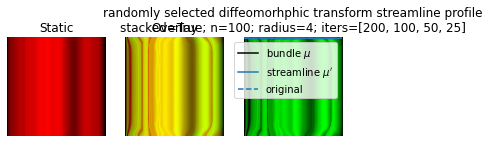

diffeomorphic calculation 1889.7046 seconds
(1614, 100)


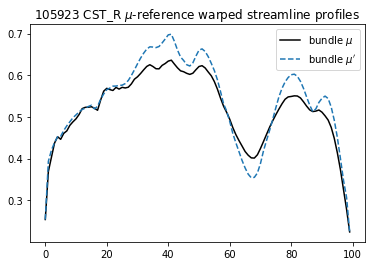

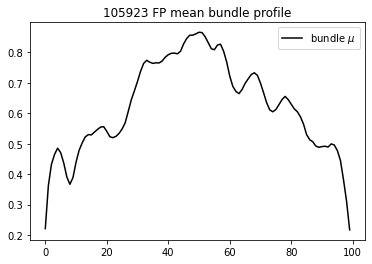

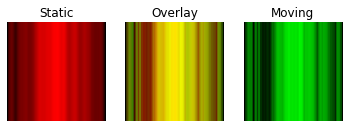

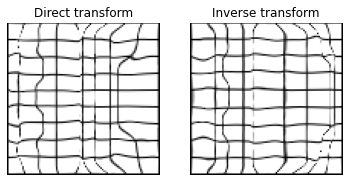

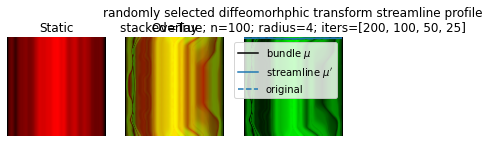

diffeomorphic calculation 603.0497 seconds
(520, 100)


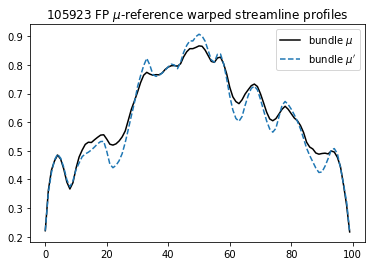

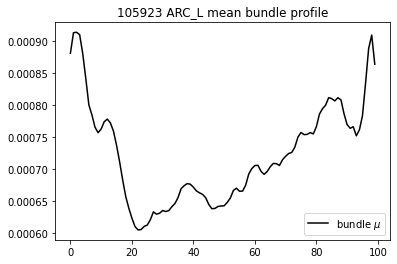

diffeomorphic calculation 508.8987 seconds
(389, 100)


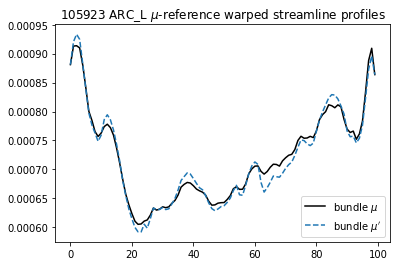

105923 ARC_R no streamlines!


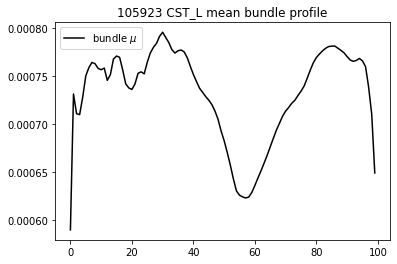

diffeomorphic calculation 927.1573 seconds
(896, 100)


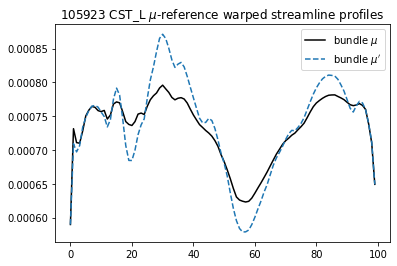

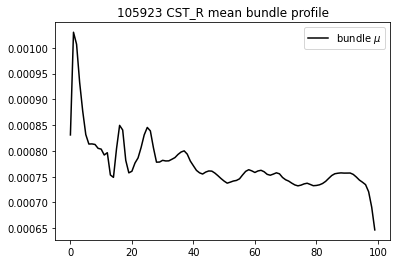

diffeomorphic calculation 1878.8921 seconds
(1614, 100)


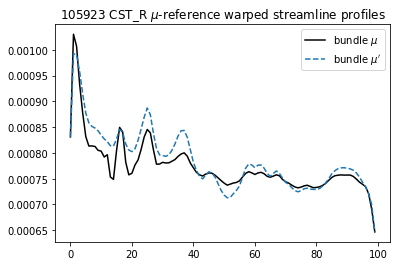

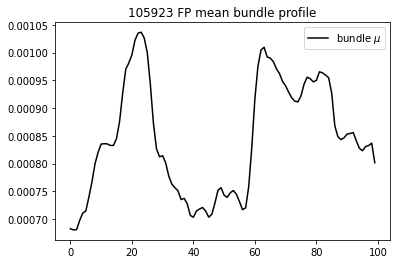

diffeomorphic calculation 586.9373 seconds
(520, 100)


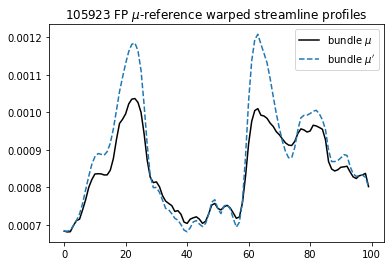

103818  \
dti_fa  {'ARC_L': [0.22033323, 0.28081027, 0.30290437,...   
dti_md  {'ARC_L': [0.00076966896, 0.0007918377, 0.0008...   

                                                   105923  
dti_fa  {'ARC_L': [0.21574506, 0.28932473, 0.3265842, ...  
dti_md  {'ARC_L': [0.0008810255, 0.00092050026, 0.0009...

retest


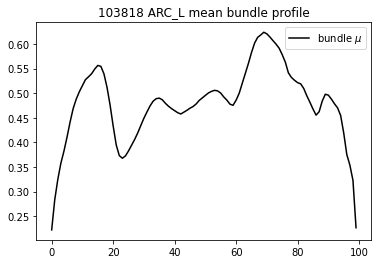

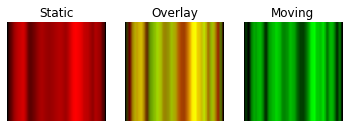

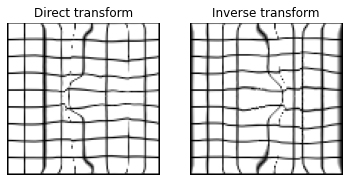

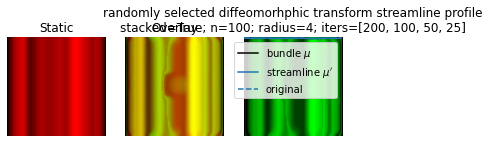

diffeomorphic calculation 1753.6046 seconds
(1610, 100)


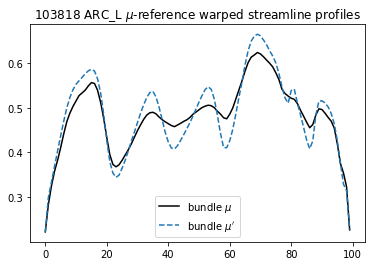

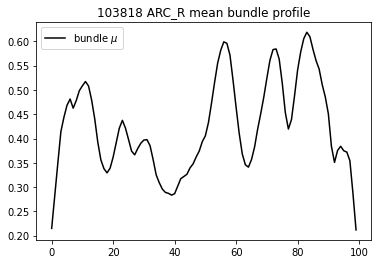

diffeomorphic calculation 142.7824 seconds
(169, 100)


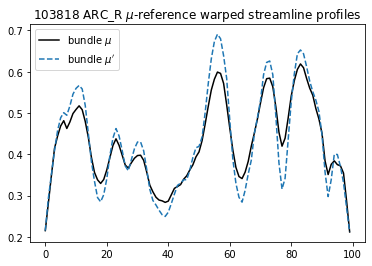

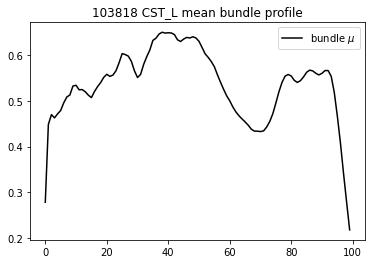

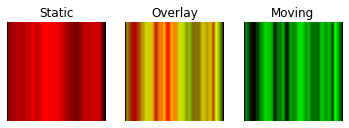

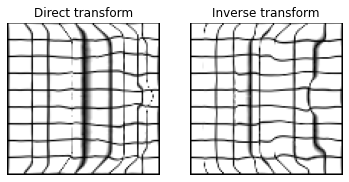

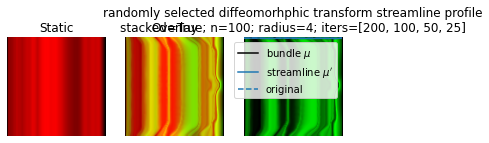

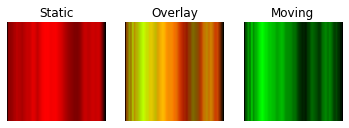

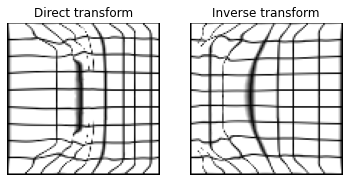

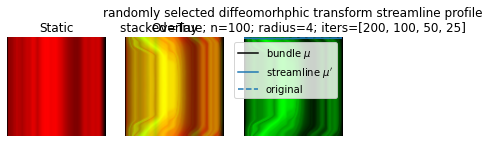

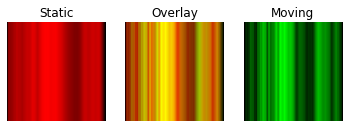

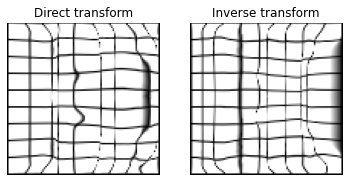

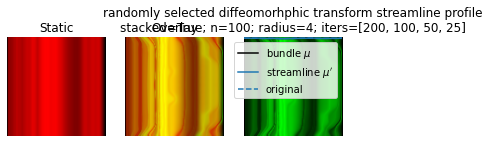

diffeomorphic calculation 3697.7749 seconds
(3220, 100)


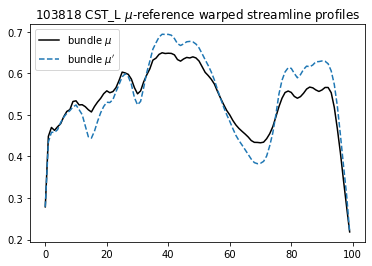

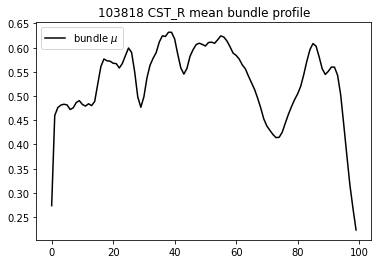

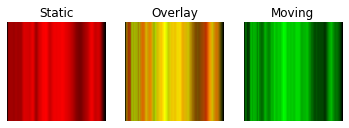

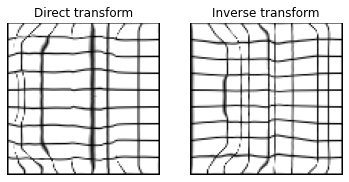

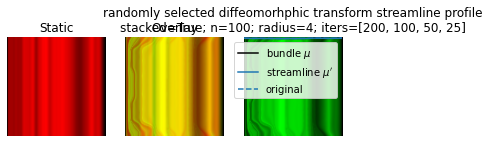

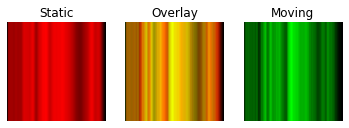

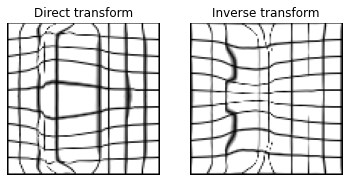

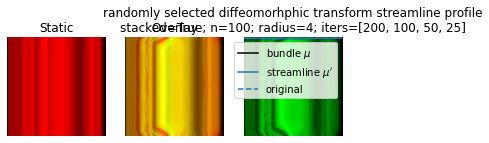

diffeomorphic calculation 3756.2570 seconds
(2808, 100)


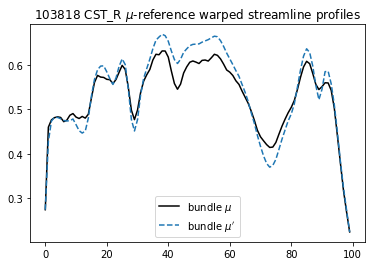

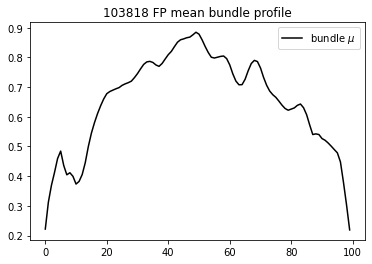

diffeomorphic calculation 1590.8884 seconds
(1132, 100)


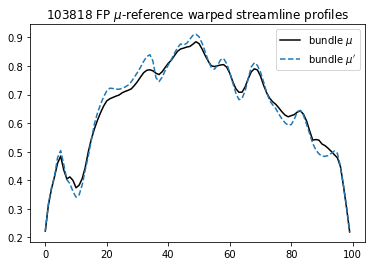

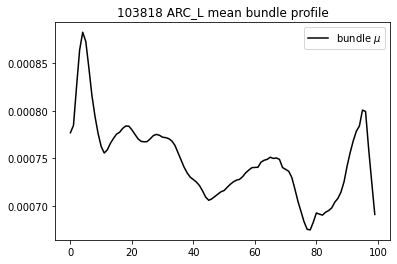

diffeomorphic calculation 2135.2416 seconds
(1610, 100)


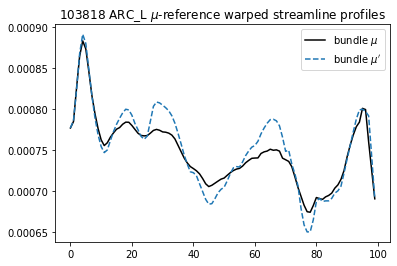

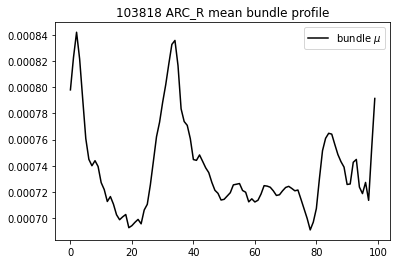

diffeomorphic calculation 200.5250 seconds
(169, 100)


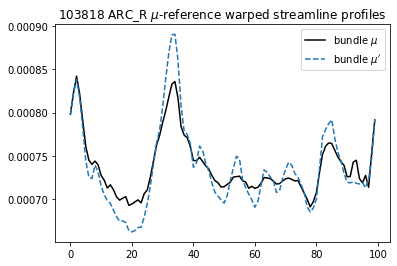

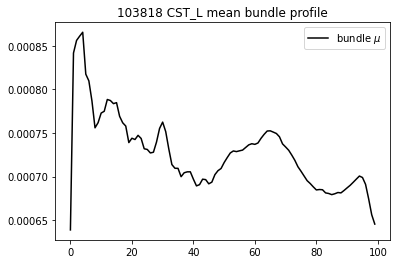

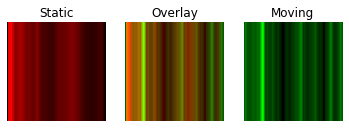

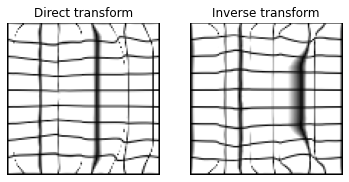

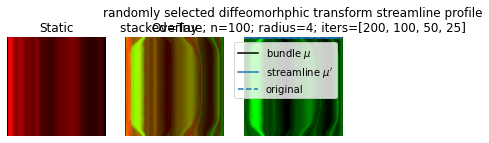

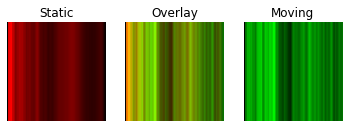

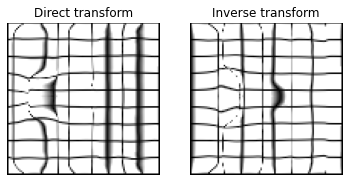

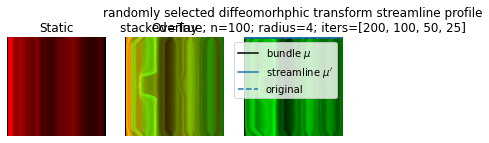

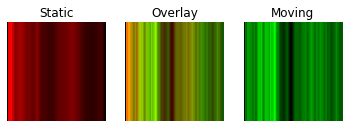

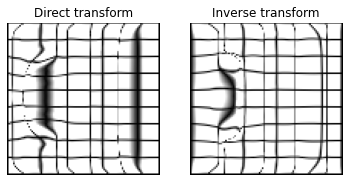

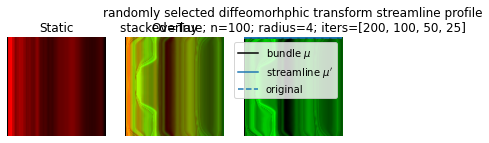

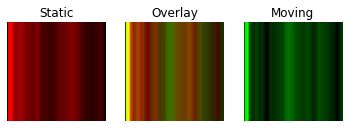

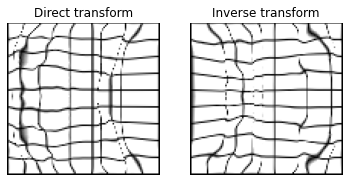

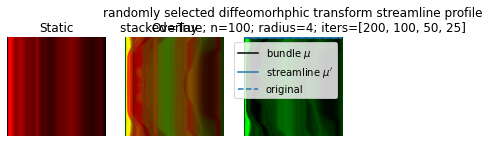

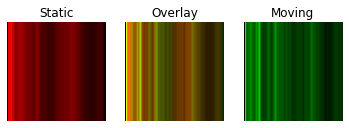

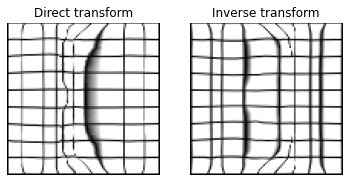

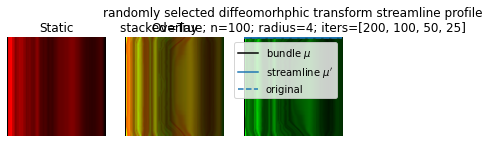

diffeomorphic calculation 4786.6583 seconds
(3220, 100)


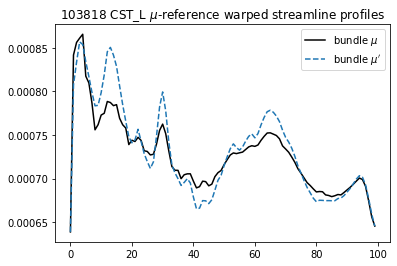

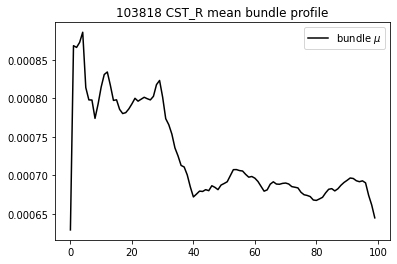

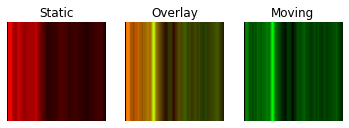

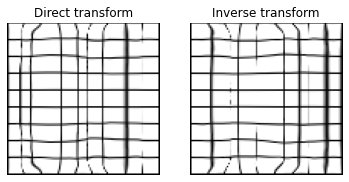

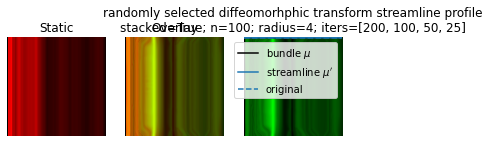

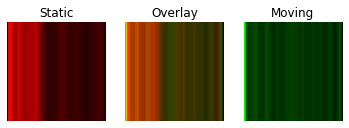

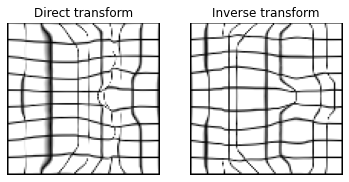

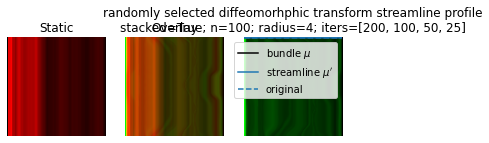

diffeomorphic calculation 4037.0742 seconds
(2808, 100)


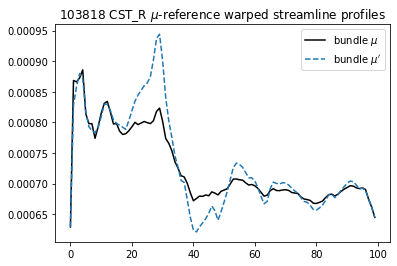

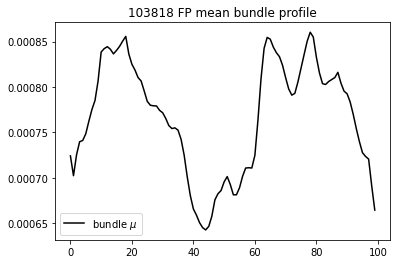

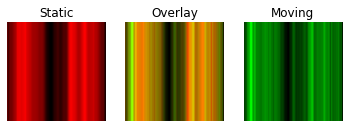

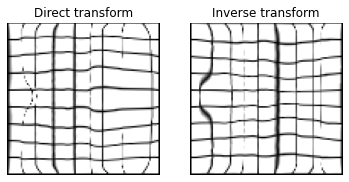

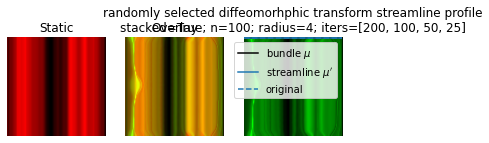

diffeomorphic calculation 1531.0564 seconds
(1132, 100)


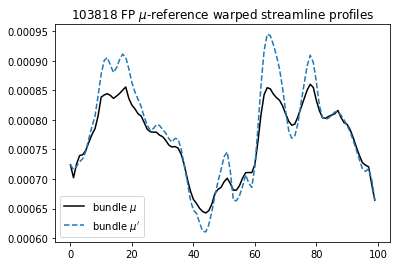

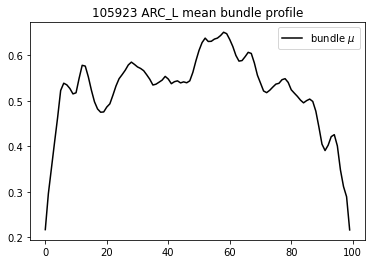

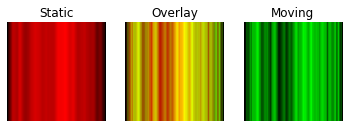

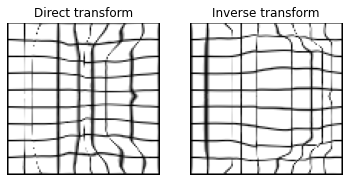

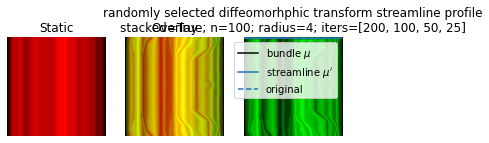

diffeomorphic calculation 392.8386 seconds
(290, 100)


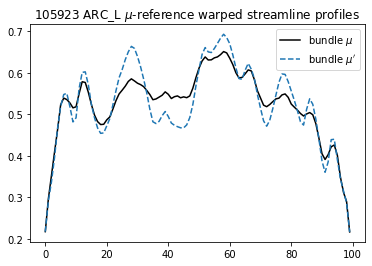

105923 ARC_R no streamlines!


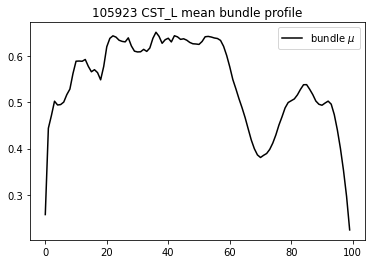

diffeomorphic calculation 1855.8928 seconds
(1362, 100)


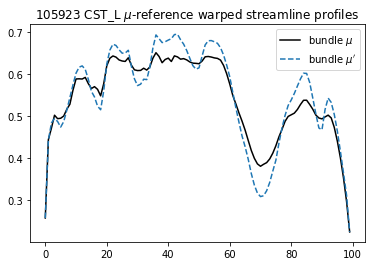

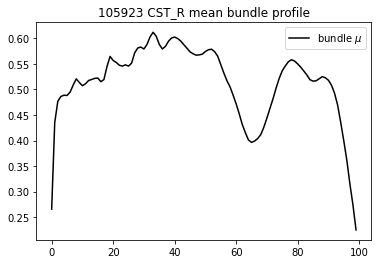

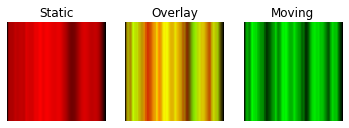

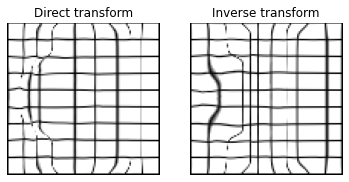

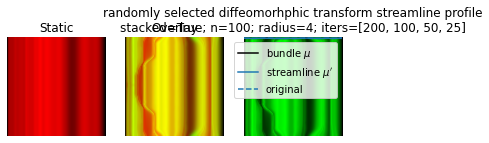

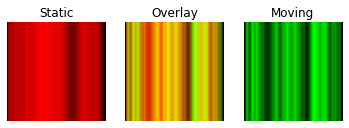

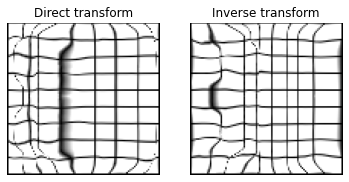

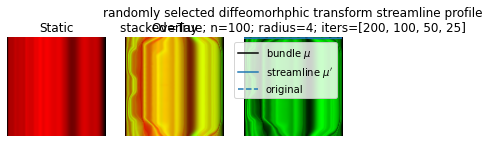

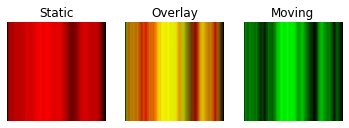

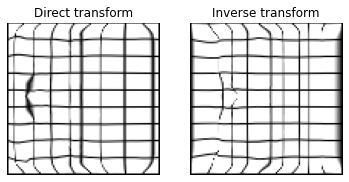

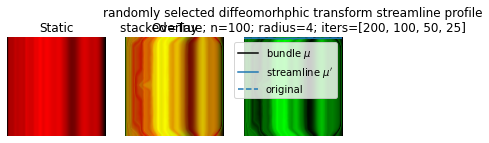

diffeomorphic calculation 2618.4275 seconds
(1743, 100)


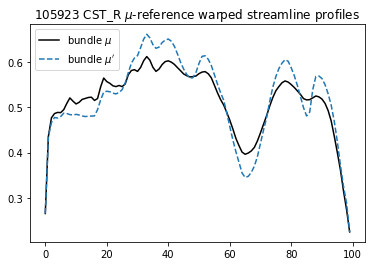

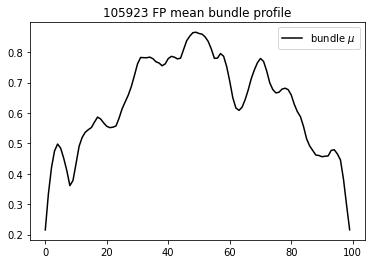

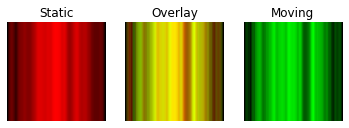

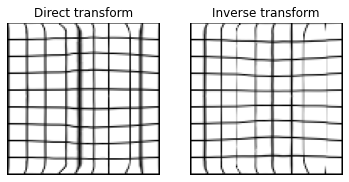

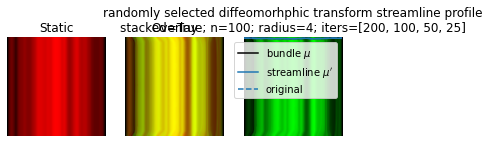

diffeomorphic calculation 705.8337 seconds
(455, 100)


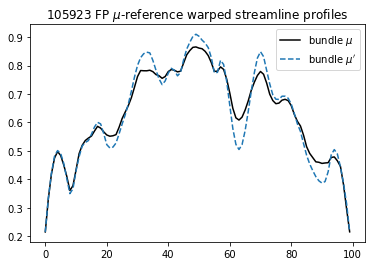

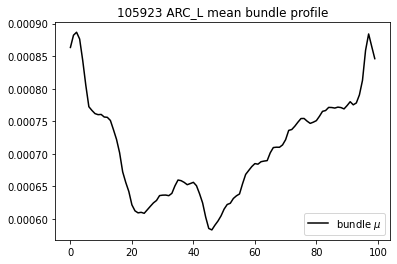

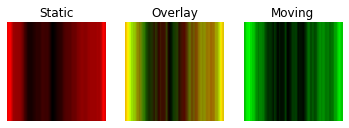

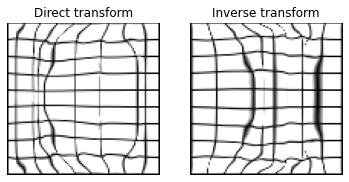

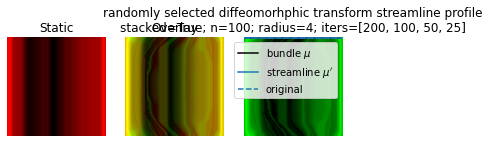

diffeomorphic calculation 526.0155 seconds
(290, 100)


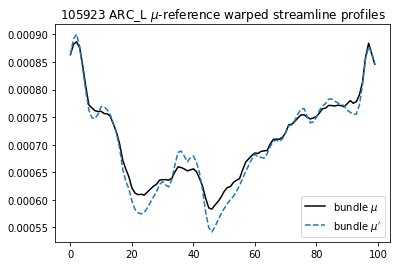

105923 ARC_R no streamlines!


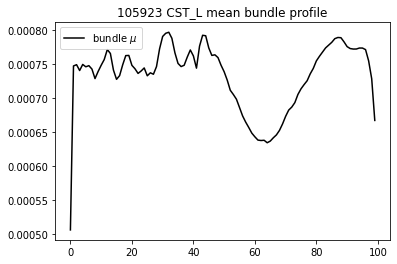

diffeomorphic calculation 2153.7566 seconds
(1362, 100)


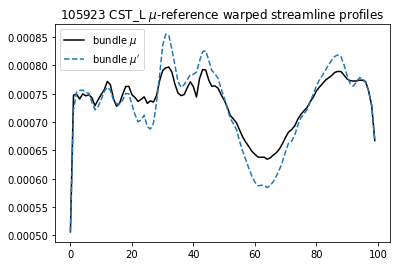

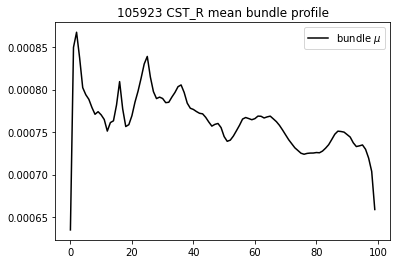

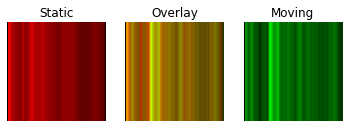

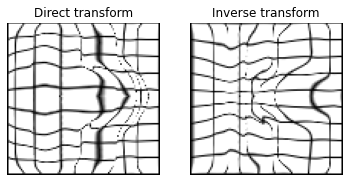

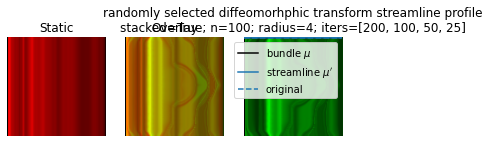

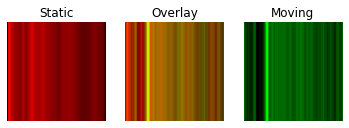

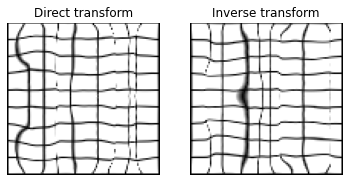

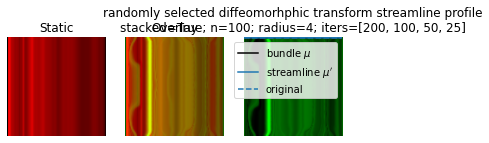

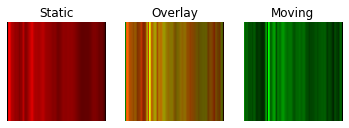

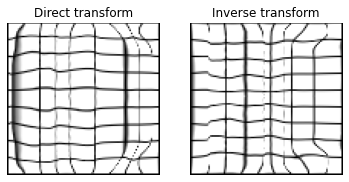

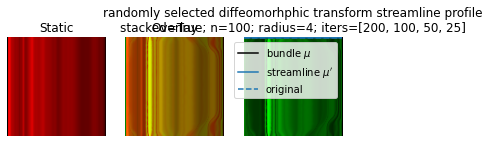

diffeomorphic calculation 2624.3898 seconds
(1743, 100)


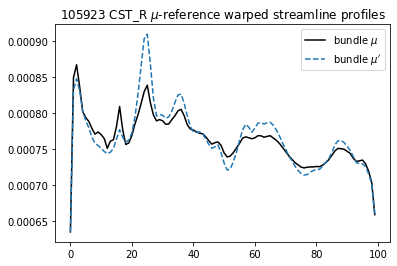

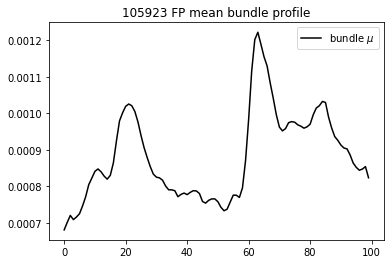

diffeomorphic calculation 706.8386 seconds
(455, 100)


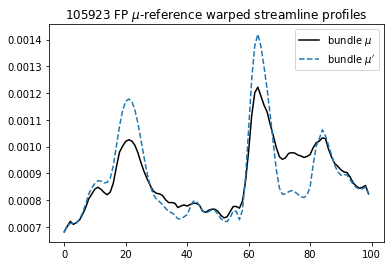

103818  \
dti_fa  {'ARC_L': [0.22229724, 0.2994249, 0.33378482, ...   
dti_md  {'ARC_L': [0.0007769264, 0.0007861417, 0.00082...   

                                                   105923  
dti_fa  {'ARC_L': [0.21692199, 0.2907766, 0.33690053, ...  
dti_md  {'ARC_L': [0.00086336496, 0.000891687, 0.00090...

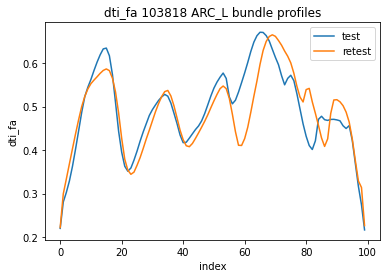

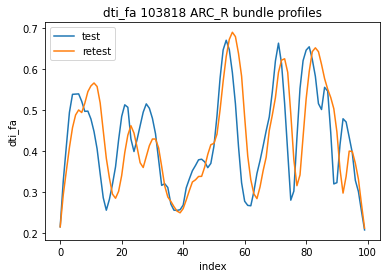

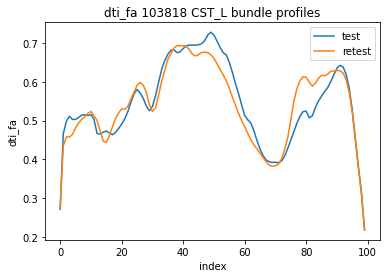

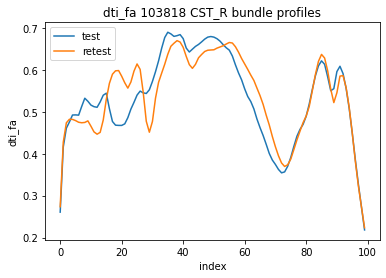

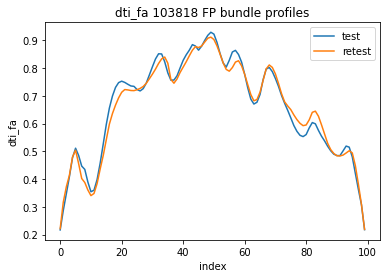

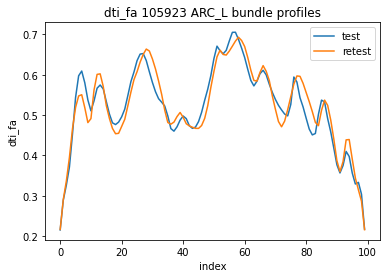

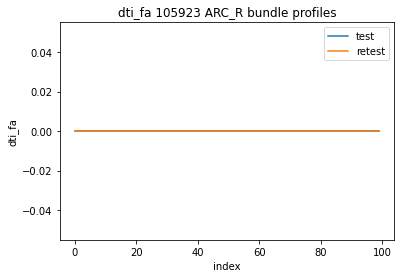

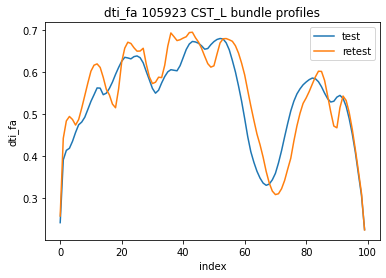

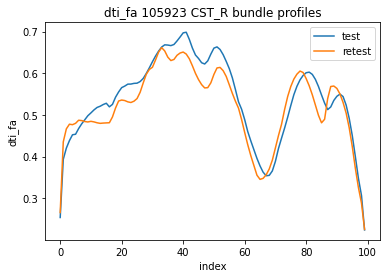

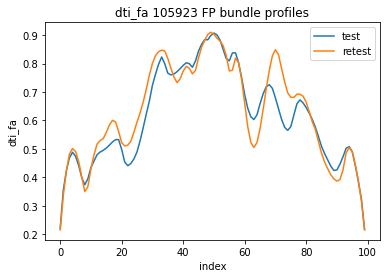

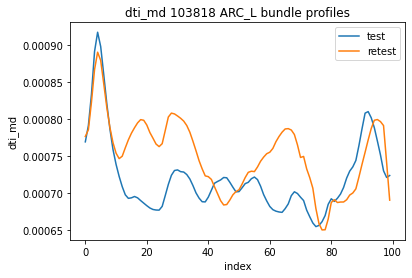

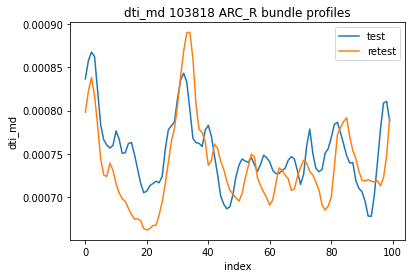

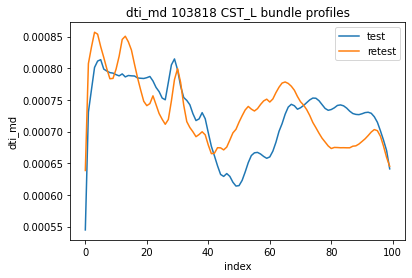

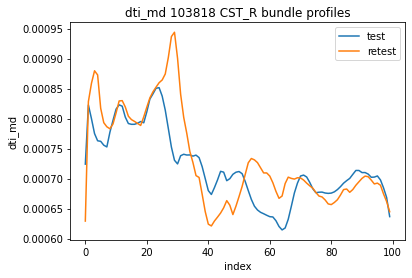

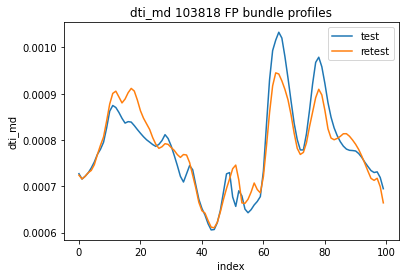

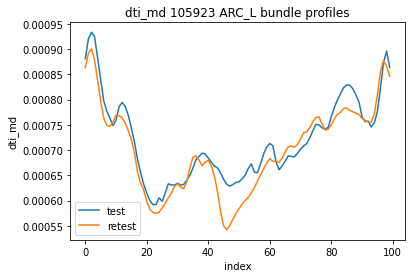

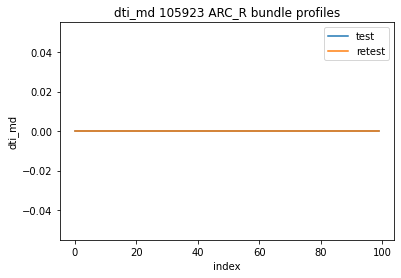

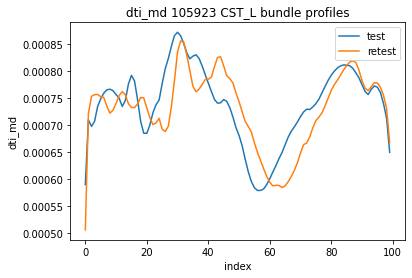

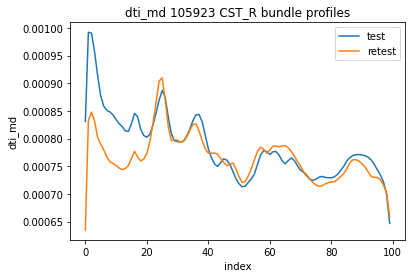

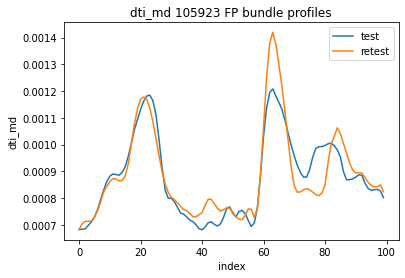

In [14]:
diffeomorphic_correlations = get_test_retest_diffeomorphic_bundle_profile_correlations()

ARC_L     ARC_R     CST_L     CST_R        FP
103818  0.856195  0.683599  0.933392  0.889153  0.989254
105923  0.958768  0.000000  0.895492  0.953810  0.943499

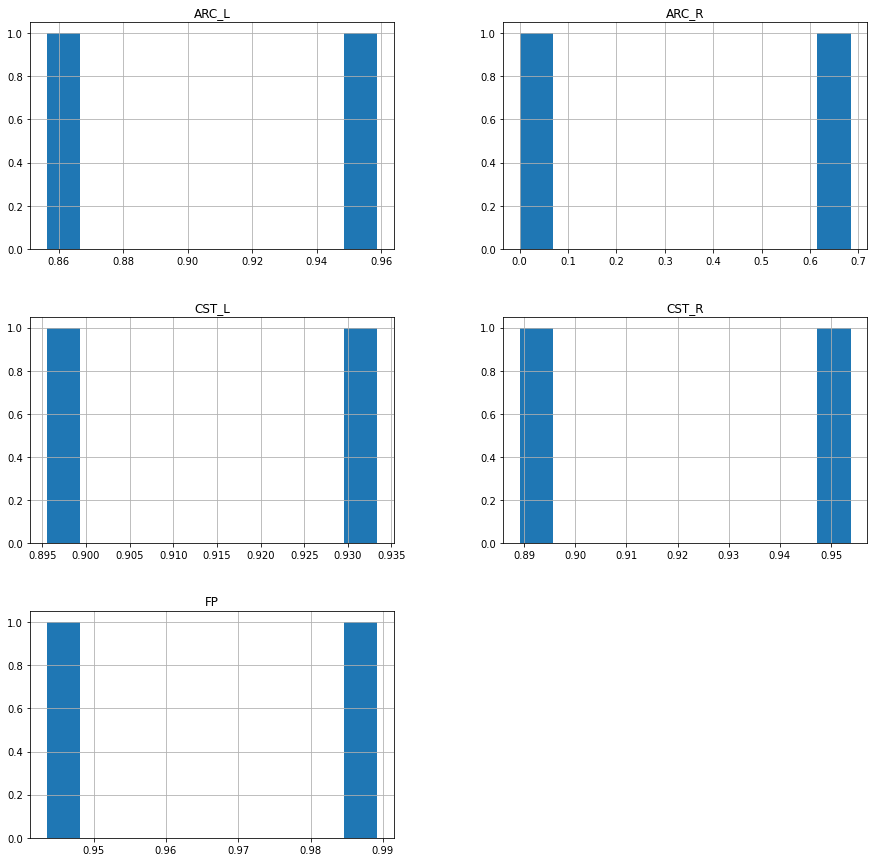

In [65]:
fa_diffeomorphic_correlations = pd.DataFrame.from_dict(diffeomorphic_correlations['dti_fa'])

display(fa_diffeomorphic_correlations.T)

ax = fa_diffeomorphic_correlations.T.hist(figsize=(15, 15))

ARC_L     ARC_R     CST_L     CST_R        FP    median
mean        0.907482  0.341799  0.914442  0.921482  0.966377  0.914442
std         0.072530  0.483377  0.026800  0.045719  0.032354       NaN
double_std  0.145061  0.966754  0.053599  0.091437  0.064707       NaN

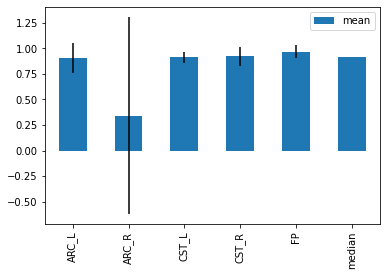

In [66]:
fa_diffeomorphic_correlations_agg = fa_diffeomorphic_correlations.agg(['mean', 'std'], axis=1)
fa_diffeomorphic_correlations_agg['double_std'] = 2 * fa_diffeomorphic_correlations_agg['std']

median = fa_diffeomorphic_correlations_agg['mean'].median(axis=0)
fa_diffeomorphic_correlations_agg = fa_diffeomorphic_correlations_agg.append(pd.Series(name='median', dtype=float))
fa_diffeomorphic_correlations_agg.at['median', 'mean'] = median

display(fa_diffeomorphic_correlations_agg.T)

ax = fa_diffeomorphic_correlations_agg.plot.bar(y='mean', yerr='double_std')

### NOTE: using values from the other notebook

In [67]:
# baseline = pd.Series([0.934111, 0.373226, 0.956361, 0.929467, 0.979886])
baseline = pd.Series([0.934111, 0.373226, 0.956361, 0.929467, 0.979886])
baseline.index=bundle_names
median = baseline.median(axis=0)
baseline.append(pd.Series(name='median', dtype=float))
baseline.at['median'] = median
display(baseline)

ARC_L     0.934111
ARC_R     0.373226
CST_L     0.956361
CST_R     0.929467
FP        0.979886
median    0.934111
dtype: float64

In [68]:
display(fa_diffeomorphic_correlations_agg['mean'])

ARC_L     0.907482
ARC_R     0.341799
CST_L     0.914442
CST_R     0.921482
FP        0.966377
median    0.914442
Name: mean, dtype: float64

In [69]:
# profile_reliability = pd.concat([fa_correlations_agg['mean'], fa_diffeomorphic_correlations_agg['mean'], fa_correlations_agg['mean'] - fa_diffeomorphic_correlations_agg['mean']], axis=1, keys=['baseline', '$\mu$ dtw', 'diff'])
profile_reliability = pd.concat([baseline, fa_diffeomorphic_correlations_agg['mean'], baseline - fa_diffeomorphic_correlations_agg['mean']], axis=1, keys=['baseline', 'diffeomorph', 'diff'])
display(profile_reliability.T)

ARC_L     ARC_R     CST_L     CST_R        FP    median
baseline     0.934111  0.373226  0.956361  0.929467  0.979886  0.934111
diffeomorph  0.907482  0.341799  0.914442  0.921482  0.966377  0.914442
diff         0.026629  0.031427  0.041919  0.007985  0.013509  0.019669

<AxesSubplot:title={'center':'profile reliability'}>

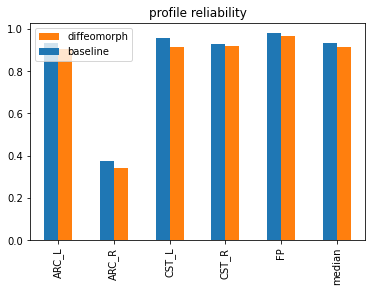

In [100]:
profile_reliability[['baseline','diffeomorph']].plot(kind='bar', title='profile reliability')